##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [2]:
orig_df = pd.read_csv('/kaggle/input/lvmpd-stats/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [3]:
df = pd.read_csv('/kaggle/input/lvmpd-stats/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [4]:
df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [6]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [7]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


#### 1a)

In [8]:
print(df.head())

            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  


**Column Descriptions**

* **X and Y:** These columns represent spatial coordinates, such as longitude and latitude.
* **Area_Command:** This column represents the area or division within the law enforcement agency.
* **NIBRSOffenseCode:** This column contains codes for different types of criminal offenses.
* **VictimCount:** This column represents the number of victims related to a reported incident.
* **DayOfWeek:** This column indicates the day of the week when the incident was reported.
* **Time:** This column represents the hour of the day when the incident was reported.


#### 1b)

The target variable is **"VictimCount,"** and the input variables (features) include **"X and Y," "Area_Command," "NIBRSOffenseCode," "DayOfWeek," and "Time."** The goal of your predictive model is to use these features to make predictions about the number of persons involved in accidents.

#### 1c)

In [9]:
print(df.describe())

                X           Y  Area_Command  NIBRSOffenseCode   DayOfWeek  \
count  275.000000  275.000000    275.000000        275.000000  275.000000   
mean  -115.159326   36.143360      3.978182          0.909091    2.981818   
std      0.101294    0.118418      3.045799          0.334878    1.924590   
min   -116.000000   35.068419      0.000000          0.000000    0.000000   
25%   -115.209198   36.114704      1.000000          1.000000    1.000000   
50%   -115.149945   36.152415      3.000000          1.000000    3.000000   
75%   -115.105200   36.183854      6.000000          1.000000    5.000000   
max   -114.625570   37.000000     11.000000          2.000000    6.000000   

             Time  VictimCount  
count  275.000000   275.000000  
mean    11.236364     0.712727  
std      7.039937     0.978427  
min      0.000000     0.000000  
25%      5.000000     0.000000  
50%     11.000000     0.000000  
75%     18.000000     1.000000  
max     23.000000     6.000000  


In [10]:
# The features latitude and longitude will be required to be normalized.

min_latitude = min(df['X'])
min_longitude = min(df['Y'])

df['X'] = df['X'] - min_latitude
df['Y'] = df['Y'] - min_longitude

| Column | Range |
|---|---|
| X | -116 to -114.63 |
| Y | 35.07 to 37 |
| Area_Command | 0 to 11 |
| NIBRSOffenseCode | 0 to 2 |
| DayOfWeek | 0 to 6 |
| Time | 0 to 23 |
| VictimCount | 0 to 6 |

#### Scaling

For columns like X, Y, and Time, it's generally a good idea to apply Min-Max scaling (scaling to a range of [0, 1]) or Standardization (Z-score normalization) to bring the features to a common scale. Scaling can be beneficial for linear regression and neural network-based models.

#### Shifting

Shifting to have a mean of 0 may not be necessary unless you observe a significant bias in the data. If the distribution of these columns is approximately symmetric and centered around zero, shifting may not provide substantial benefits.

#### Normalization

Normalization (Z-score normalization) can be applied to the features if their distribution is not approximately Gaussian. It can help make the data more amenable to algorithms like linear regression. However, for some regression algorithms, it might not be necessary.

#### VictimCount

The treatment of the VictimCount column depends on its distribution. If the distribution is heavily skewed, you might consider applying a log transformation to it to make it more symmetrical. This can be particularly useful if you notice that a few large values are causing skewness.

#### Evaluate

The most critical step is to experiment with different preprocessing techniques and evaluate their impact on your model's performance. Try different combinations of preprocessing steps, and use cross-validation to assess which preprocessing approach works best for your specific regression problem.


## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [11]:
# Define your input and target variables
features = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']]
target = df['VictimCount']

# Convert your input and target variables to PyTorch tensors
features_tensor = torch.tensor(features.values, dtype=torch.float32)
target_tensor = torch.tensor(target.values, dtype=torch.float32).view(-1, 1)  # Reshape to have one column

# Define batch size
batch_size = 32

# Create a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

# Create training and testing datasets
train_size = int(0.8 * len(features_tensor))
test_size = len(features_tensor) - train_size

train_dataset = CustomDataset(features_tensor[:train_size], target_tensor[:train_size])
test_dataset = CustomDataset(features_tensor[train_size:], target_tensor[train_size:])

# Create DataLoader objects for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the shape of the batched data (training DataLoader)
for batch_features, batch_target in train_loader:
    print("Batch features shape:", batch_features.shape)
    print("Batch target shape:", batch_target.shape)
    print(batch_features[3, :], "Size:", batch_features[3, :].shape)
    break


Batch features shape: torch.Size([32, 6])
Batch target shape: torch.Size([32, 1])
tensor([ 0.7259,  1.0895,  6.0000,  0.0000,  0.0000, 17.0000]) Size: torch.Size([6])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

Epoch 1/100, Validation Loss (MSE): 1.6272
Epoch 2/100, Validation Loss (MSE): 1.7149
Epoch 3/100, Validation Loss (MSE): 1.6559
Epoch 4/100, Validation Loss (MSE): 1.7147
Epoch 5/100, Validation Loss (MSE): 1.6555
Epoch 6/100, Validation Loss (MSE): 1.6340
Epoch 7/100, Validation Loss (MSE): 1.6314
Epoch 8/100, Validation Loss (MSE): 1.6498
Epoch 9/100, Validation Loss (MSE): 1.6305
Epoch 10/100, Validation Loss (MSE): 1.6175
Epoch 11/100, Validation Loss (MSE): 1.6140
Epoch 12/100, Validation Loss (MSE): 1.6092
Epoch 13/100, Validation Loss (MSE): 1.6005
Epoch 14/100, Validation Loss (MSE): 1.5979
Epoch 15/100, Validation Loss (MSE): 1.6113
Epoch 16/100, Validation Loss (MSE): 1.5862
Epoch 17/100, Validation Loss (MSE): 1.5901
Epoch 18/100, Validation Loss (MSE): 1.6093
Epoch 19/100, Validation Loss (MSE): 1.5820
Epoch 20/100, Validation Loss (MSE): 1.5965
Epoch 21/100, Validation Loss (MSE): 1.5764
Epoch 22/100, Validation Loss (MSE): 1.6001
Epoch 23/100, Validation Loss (MSE): 1.60

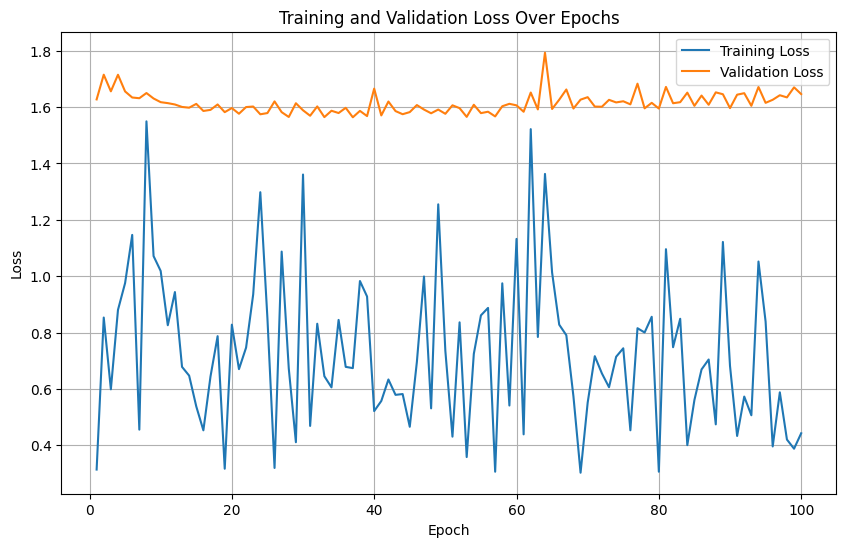

In [12]:
# Define the neural network architecture
class YourModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(YourModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)  # Second fully connected layer
        self.fc3 = nn.Linear(hidden_size2, output_size)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation in the first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation in the second layer
        x = self.fc3(x)  # Output layer
        return x

# Define the input, hidden, and output dimensions
input_size = 6  # Number of input features
hidden_size1 = 64  # Number of neurons in the first hidden layer
hidden_size2 = 64  # Number of neurons in the second hidden layer
output_size = 1  # For regression, typically a single output neuron

# Instantiate your model
model = YourModel(input_size, hidden_size1, hidden_size2, output_size)

# Define the optimizer and learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with a learning rate of 0.001

# Define your loss function (e.g., Mean Squared Error for regression)
criterion = nn.MSELoss()  # Mean Squared Error loss function

# Number of training epochs
num_epochs = 100  # The number of times to iterate over the entire training dataset

train_losses = []  # List to store training losses
val_losses = []  # List to store validation losses

# Training and evaluation loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    for train_batch_X, train_batch_y in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        train_predictions = model(train_batch_X)  # Forward pass
        train_loss = criterion(train_predictions, train_batch_y)  # Calculate the loss
        train_loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights

    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for val_batch_X, val_batch_y in test_loader:
            val_predictions = model(val_batch_X)  # Forward pass for validation data
            val_loss += criterion(val_predictions, val_batch_y)  # Calculate the validation loss

    # Calculate the average validation loss for the current epoch
    average_val_loss = val_loss / len(test_loader)

    train_losses.append(train_loss.item())  # Store training loss
    val_losses.append(average_val_loss.item())  # Store validation loss

    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss (MSE): {average_val_loss.item():.4f}")

# Training is complete
final_train_loss = train_losses[-1]  # Final training loss
final_val_loss = val_losses[-1]  # Final validation loss

print(f"Final Training MSE: {final_train_loss:.4f}")
print(f"Final Validation MSE: {final_val_loss:.4f}")

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

Epoch 1/100, Test Loss: 1.8512, Test Accuracy: 36.36%
Epoch 2/100, Test Loss: 1.7468, Test Accuracy: 32.73%
Epoch 3/100, Test Loss: 1.5485, Test Accuracy: 30.91%
Epoch 4/100, Test Loss: 1.3834, Test Accuracy: 30.91%
Epoch 5/100, Test Loss: 1.1918, Test Accuracy: 54.55%
Epoch 6/100, Test Loss: 1.1478, Test Accuracy: 54.55%
Epoch 7/100, Test Loss: 1.1370, Test Accuracy: 54.55%
Epoch 8/100, Test Loss: 1.1279, Test Accuracy: 54.55%
Epoch 9/100, Test Loss: 1.1105, Test Accuracy: 54.55%
Epoch 10/100, Test Loss: 1.1058, Test Accuracy: 54.55%
Epoch 11/100, Test Loss: 1.1047, Test Accuracy: 54.55%
Epoch 12/100, Test Loss: 1.0913, Test Accuracy: 54.55%
Epoch 13/100, Test Loss: 1.0932, Test Accuracy: 54.55%
Epoch 14/100, Test Loss: 1.0876, Test Accuracy: 54.55%
Epoch 15/100, Test Loss: 1.0889, Test Accuracy: 54.55%
Epoch 16/100, Test Loss: 1.0893, Test Accuracy: 54.55%
Epoch 17/100, Test Loss: 1.0874, Test Accuracy: 54.55%
Epoch 18/100, Test Loss: 1.0799, Test Accuracy: 54.55%
Epoch 19/100, Test 

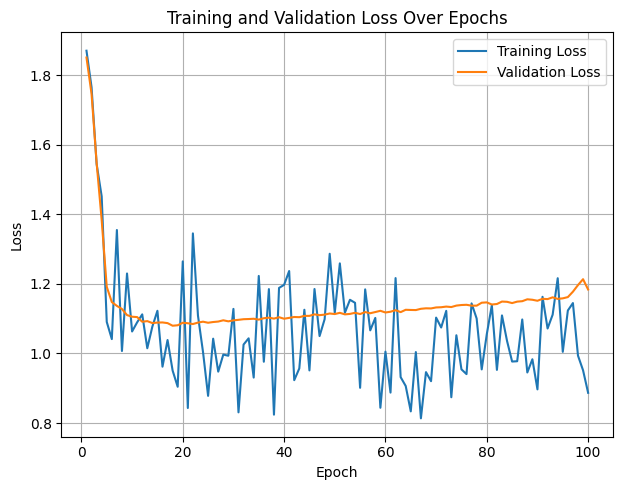

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load your data into X and y

# Assuming you have X and y ready, load your data

X_tensor = torch.tensor(features.values, dtype=torch.float32)

# Extract the 'target' column and convert it to a NumPy array
y_array = df['VictimCount'].values

# Convert the NumPy array to a PyTorch tensor and reshape it if necessary
y_tensor = torch.tensor(y_array, dtype=torch.long)
y_tensor = y_tensor.view(-1)

# Define batch size
batch_size = 32  # You can adjust this to your preference

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Define your neural network model with more layers
class YourImprovedModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(YourImprovedModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)  # Increase the hidden layer size
        self.fc2 = nn.Linear(256, 128)  # Add an extra hidden layer
        self.fc3 = nn.Linear(128, 64)  # Additional hidden layer
        self.fc4 = nn.Linear(64, 32)  # Additional hidden layer
        self.fc5 = nn.Linear(32, 16)  # Additional hidden layer
        self.fc6 = nn.Linear(16, 8)  # Additional hidden layer
        self.fc7 = nn.Linear(8, output_dim)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = self.fc7(x)
        return x

# Determine the number of classes from the target labels
num_classes = len(torch.unique(y_tensor))

# Instantiate your improved model with the correct number of output dimensions
model = YourImprovedModel(X_train.shape[1], num_classes)

# Define the optimizer and learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define your loss function (Cross-Entropy for classification)
criterion = nn.CrossEntropyLoss()

# Number of training epochs
num_epochs = 100

# Create DataLoader objects for training and testing
train_dataset = TensorDataset(X_train, y_train)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Remaining code stays the same...


# Training and evaluation loop
test_accuracies = []
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_correct = 0
    total_samples = 0

    for batch_X, batch_y in train_data_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

        # Calculate the number of correct predictions in the batch
        _, predicted = torch.max(predictions, 1)
        total_correct += (predicted == batch_y).sum().item()
        total_samples += len(batch_y)

    accuracy = total_correct / total_samples if total_samples > 0 else 0  # Avoid division by zero

    train_losses.append(loss.item())

    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for test_X, test_y in test_data_loader:
            test_predictions = model(test_X)
            test_loss += criterion(test_predictions, test_y)

            # Calculate the number of correct predictions in the batch
            _, predicted = torch.max(test_predictions, 1)
            total_correct += (predicted == test_y).sum().item()
            total_samples += len(test_y)

    average_test_loss = test_loss / len(test_data_loader)
    test_accuracy = total_correct / total_samples if total_samples > 0 else 0  # Avoid division by zero

    test_accuracies.append(test_accuracy)
    test_losses.append(average_test_loss.item())

    print(f"Epoch {epoch + 1}/{num_epochs}, Test Loss: {average_test_loss.item():.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

# Training is complete
# Calculate final overall accuracy
model.eval()  # Set the model to evaluation mode
total_correct = 0
total_samples = 0

with torch.no_grad():
    for test_X, test_y in test_data_loader:

        # Filter out samples with invalid target labels in the test set
        valid_indices = test_y < num_classes
        test_X = test_X[valid_indices]
        test_y = test_y[valid_indices]

        # Check if there are any valid samples left
        if len(test_y) == 0:
            continue  # Skip this batch

        test_predictions = model(test_X)

        # Calculate the number of correct predictions in the batch
        _, predicted = torch.max(test_predictions, 1)
        total_correct += (predicted == test_y).sum().item()
        total_samples += len(test_y)

final_accuracy = total_correct / total_samples if total_samples > 0 else 0  # Avoid division by zero

print(f"Final Test Accuracy: {final_accuracy * 100:.2f}%")

# Create a line graph to visualize test accuracy and loss over epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

### 5a)

### Experience with Tasks 3 and 4

Tasks 3 and 4 involved two distinct machine learning problems: regression and classification. In Task 3, we tackled regression, where the goal was to predict a real number, specifically the number of crimes committed. We used a regression model and evaluated the performance of the model using the mean square error (MSE) as the loss function. On the other hand, Task 4 was a classification task, with the goal of classifying the number of crime victims into one of seven predefined categories. For this task, a classification model with a soft-max activation function and a cross-entropy loss function was used.

Comparing the results, the classifying task (Task 4) outperformed the regression task (Task 3) for this particular problem. While the regression model achieved a final Mean Squared Error of 1.5820, the classification model produced better results with a test accuracy of approximately 50.91%. This result suggests that rather than trying to predict an exact real number, it was more appropriate and effective to classify the number of crime victims into discrete categories in this context. The classification model allows for a clearer understanding of the different victim counts and how they relate to the input features, making it a better choice for this particular problem.

### 5b)

Model's Output for Misclassified Sample:
[0.3924176  0.41517037 0.04839676 0.10976459 0.00528729 0.01130355
 0.01765982]


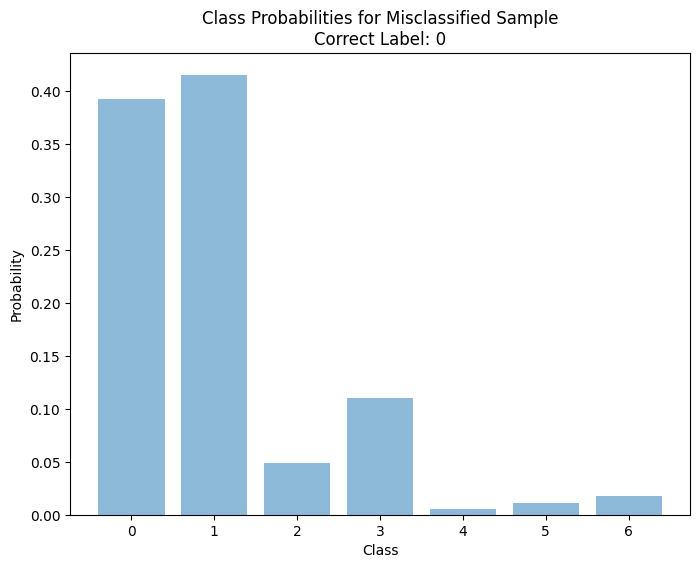

In [20]:
# Initialize lists to store misclassified samples, correct labels, class probabilities, and class labels
misclassified_samples = []
correct_labels = []
class_probabilities = []
class_labels = list(range(num_classes))  # Assuming class labels are integers from 0 to num_classes-1

# Set the model to evaluation mode
model.eval()

# Loop through the test data to find misclassified samples
with torch.no_grad():
    for test_X, test_y in test_data_loader:
        test_predictions = model(test_X)
        _, predicted = torch.max(test_predictions, 1)

        for i in range(len(test_y)):
            if predicted[i] != test_y[i]:
                # Store the misclassified sample and correct label
                misclassified_samples.append(test_X[i])
                correct_labels.append(test_y[i])

                # Calculate class probabilities for the misclassified sample
                probabilities = torch.softmax(test_predictions[i], dim=0).numpy()
                class_probabilities.append(probabilities)

# Plot the class probabilities for a misclassified sample, if any
if misclassified_samples:
    misclassified_index = 0  # You can choose a different index to visualize other misclassified samples
    misclassified_sample = misclassified_samples[misclassified_index]
    correct_label = correct_labels[misclassified_index]
    probabilities = class_probabilities[misclassified_index]

    print("Model's Output for Misclassified Sample:")
    print(probabilities)

    plt.figure(figsize=(8, 6))
    plt.bar(class_labels, probabilities, tick_label=class_labels, alpha=0.5)
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title(f'Class Probabilities for Misclassified Sample\nCorrect Label: {correct_label}')
    plt.show()
else:
    print("No misclassified samples.")


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


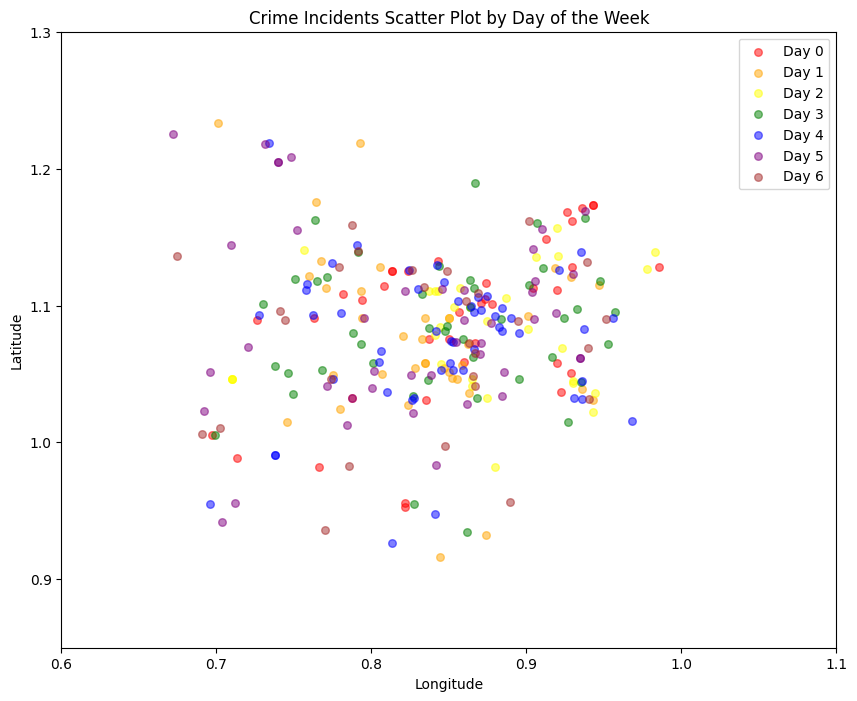

In [21]:
# Define a color mapping for days of the week
day_color_mapping = {
    0: 'red',      # Monday
    1: 'orange',   # Tuesday
    2: 'yellow',   # Wednesday
    3: 'green',    # Thursday
    4: 'blue',     # Friday
    5: 'purple',   # Saturday
    6: 'brown'     # Sunday
}

# Create a scatter plot
plt.figure(figsize=(10, 8))

for day, color in day_color_mapping.items():
    day_data = df[df['DayOfWeek'] == day]
    plt.scatter(day_data['X'], day_data['Y'], c=color, label=f'Day {day}', alpha=0.5, s=30)  # Increase 's' for thicker dots

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(0.6, 1.10)
plt.ylim(0.85, 1.30)
plt.title('Crime Incidents Scatter Plot by Day of the Week')
plt.legend(loc='upper right')

plt.show()


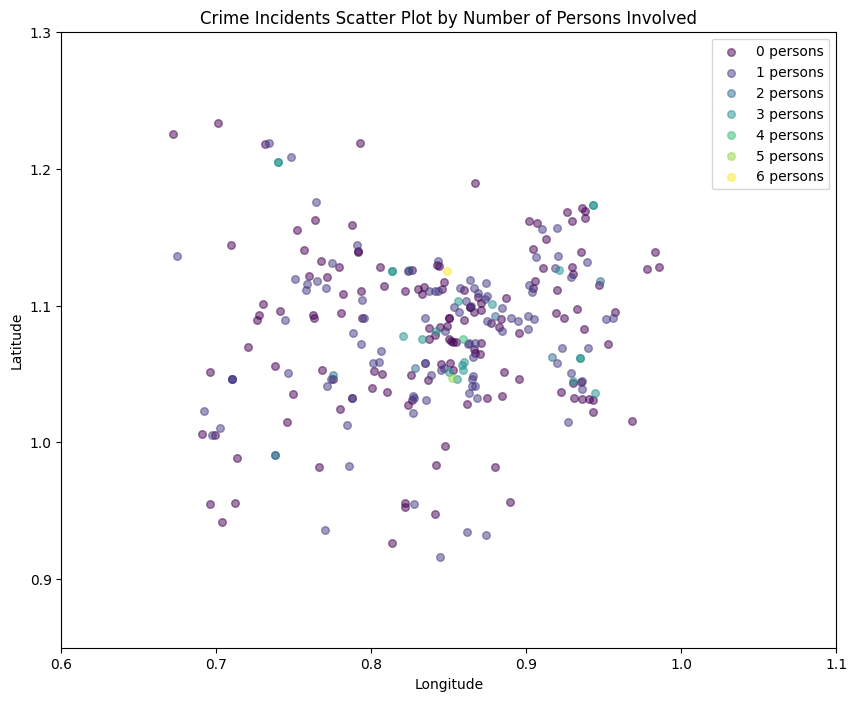

In [22]:
# Define a dynamic colormap based on the number of persons involved
colormap = plt.get_cmap('viridis')

# Determine the unique values for the number of persons involved
unique_victim_counts = df['VictimCount'].unique()
num_colors = len(unique_victim_counts)

# Create a scatter plot
plt.figure(figsize=(10, 8))

for i, persons_involved in enumerate(unique_victim_counts):
    incidents_data = df[df['VictimCount'] == persons_involved]
    color = colormap(i / (num_colors - 1))  # Normalize color based on the number of categories
    plt.scatter(incidents_data['X'], incidents_data['Y'], c=[color], label=f'{persons_involved} persons', alpha=0.5, s=30)  # Increase 's' for thicker dots

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(0.6, 1.10)
plt.ylim(0.85, 1.30)
plt.title('Crime Incidents Scatter Plot by Number of Persons Involved')
plt.legend(loc='upper right')

plt.show()


In [23]:
# Group the data by 'DayOfWeek' and count the number of crimes for each day
day_crime_counts = df['DayOfWeek'].value_counts().reset_index()
day_crime_counts.columns = ['DayOfWeek', 'CrimeCount']

# Sort the days by the number of crimes in descending order
sorted_day_crime_counts = day_crime_counts.sort_values(by='CrimeCount', ascending=False)

# Map numeric day codes to day names
day_mapping = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}
sorted_day_crime_counts['DayOfWeek'] = sorted_day_crime_counts['DayOfWeek'].map(day_mapping)

# Display the days with the most frequent crimes
print(sorted_day_crime_counts)

# Get the most frequent day
most_frequent_day = sorted_day_crime_counts.iloc[0]
print("The day with the most frequent crimes is:", most_frequent_day['DayOfWeek'])


   DayOfWeek  CrimeCount
0     Friday          51
1   Thursday          44
2   Saturday          43
3     Monday          40
4    Tuesday          37
5  Wednesday          32
6     Sunday          28
The day with the most frequent crimes is: Friday
